In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (set_init_point, prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad, create_organo
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
nf, r_in, r_out = (3, 1, 4)
organo = create_organo(nf, r_in, r_out, rot=np.pi/12)

organo.edge_df.loc[:nf, 'line_tension'] *= 2
organo.edge_df.loc[nf:2*nf-1, 'line_tension'] = 0
geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)

Reseting datasets values with new specs


      fun: 0.0039027516547474467
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.73810387e-04,  5.19462119e-04,  2.97653285e-05,  3.78231271e-04,
        1.68010260e-04, -1.89377502e-04, -7.33005113e-05, -3.35109636e-04,
       -2.82689092e-04, -2.90201539e-04, -1.09820151e-04, -8.02681331e-05])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 3
   status: 0
  success: True
        x: array([ 0.1856511 , -0.1713566 , -0.25408152, -0.06562345,  0.06783918,
        0.23669497,  0.79912887, -0.74215143, -1.09073003, -0.2833752 ,
        0.29217879,  1.02580029])

In [3]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

Force inference with tensions and pressions solved with NNLS

Solving time: 0.24268500000000026
Distance from th organo to exp organo : 0.059027862911584884
Distance from th tensions to exp tensions : 0.0029427566884235637


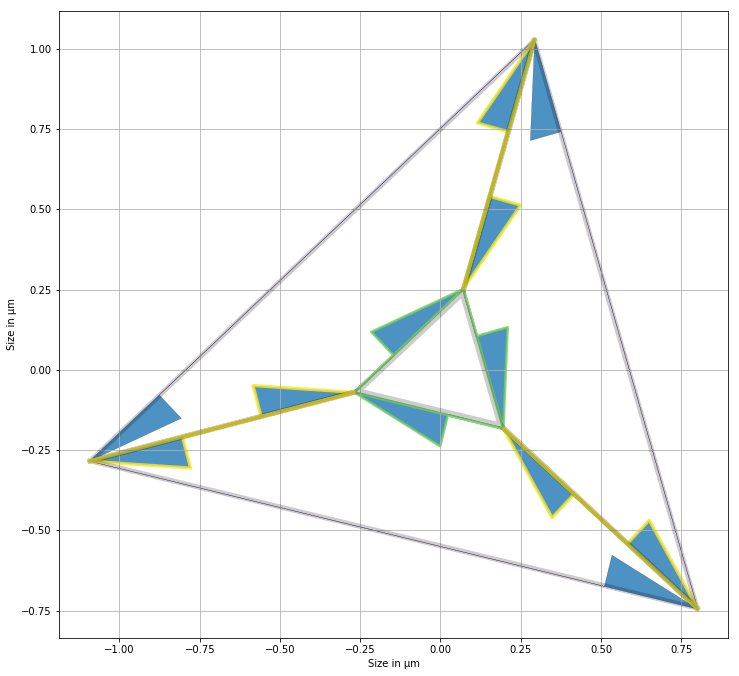

In [4]:
nb_cells = organo.Nf
initial_guess = infer_forces(organo, 'NNLS', sup_param='pressions')
start = time.clock()
pressions_organo = organo.copy()
pressions_organo.edge_df.line_tension = prepare_tensions(pressions_organo,
                                                            initial_guess['tensions'])
#print('Energy before optimization: ', model.compute_energy(pressions_organo, False))
Solver.find_energy_min(pressions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Energy after optimization: ', model.compute_energy(pressions_organo, False))
print_tensions(pressions_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, pressions_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] - initial_guess['tensions']))))

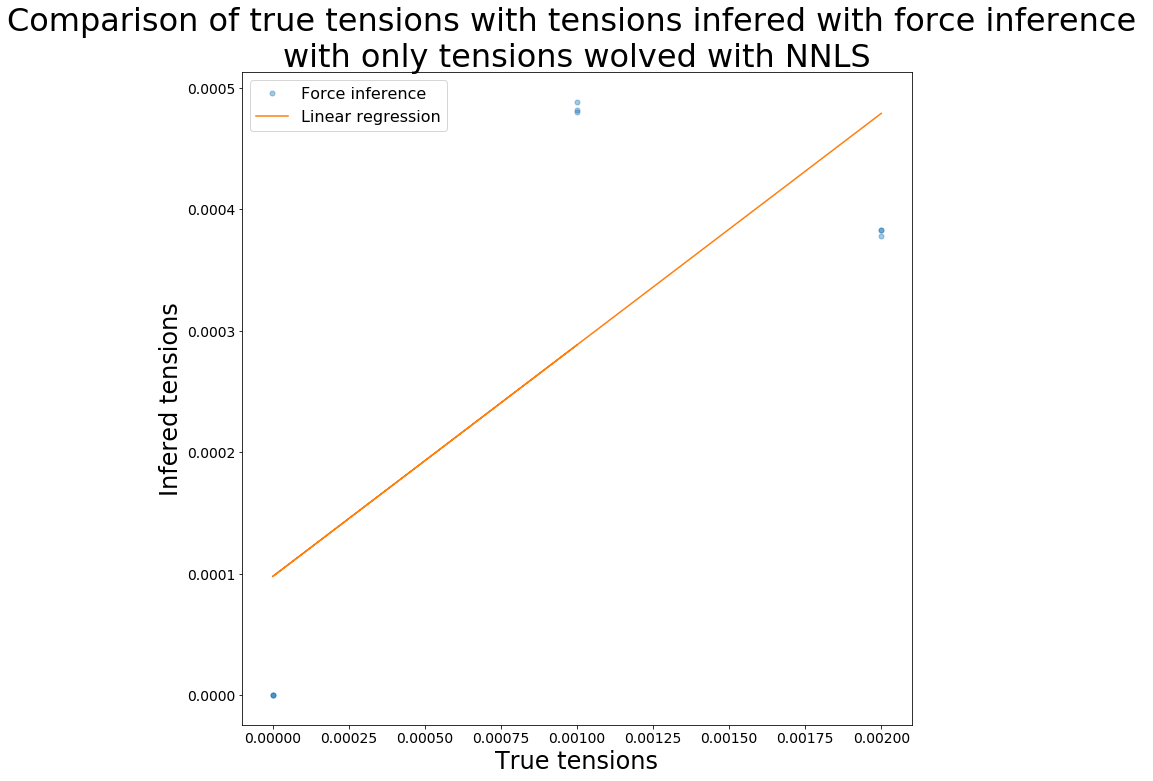

R value : 0.748305957306793 
Standard error : 0.00011954309113208013


In [5]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  initial_guess['tensions'],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

Scale factor optimization

iter   time      nfev    incumbent   f(incumbent)
   1    2.56      10      0.00000     0.00556
   2    2.95      15      0.40000     0.00518
   3    3.71      25      0.44000     0.00514
   4    4.55      36      0.44500     0.00514
Brut force search summary
              solving time: 4.547912836074829
              nb iter: 4
              nfev: 36
              x_ub: 0.4450000000000001
              ub: 0.0051355587508285965
Optimization terminated successfully.
         Current function value: 0.005105
         Iterations: 14
         Function evaluations: 28
Solving time: 9.206006


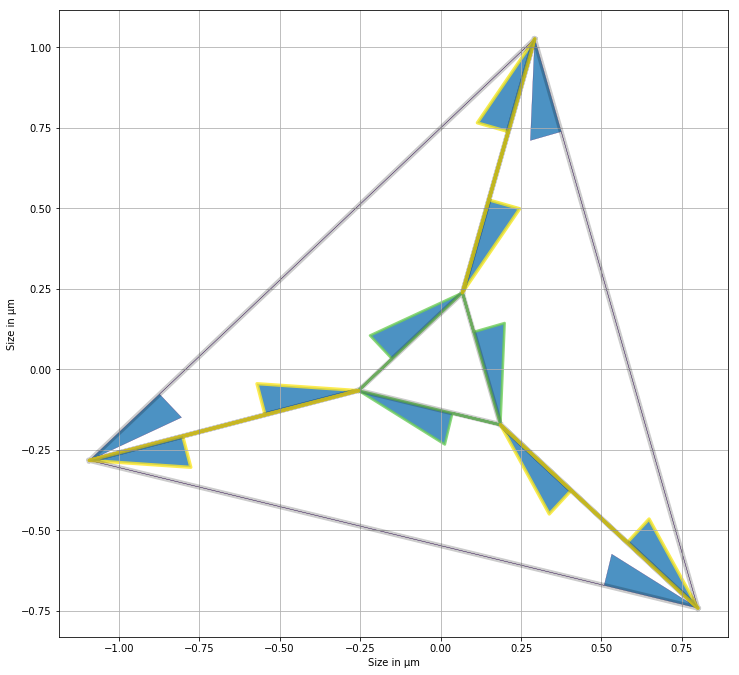

In [6]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='')
start = time.clock()
rescaled_pressions_organo = organo.copy()
opt_scale = adjust_scale(organo,
                         initial_guess['tensions'],
                         verbose=2,
                         **nm_opt)
rescaled_pressions_organo.edge_df.line_tension = prepare_tensions(rescaled_pressions_organo,
                                                                     opt_scale.x*initial_guess['tensions'])
Solver.find_energy_min(rescaled_pressions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_pressions_organo, organo)

In [7]:
dist_init_point = np.sum(np.linalg.norm(_distance(pressions_organo, rescaled_pressions_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(organo, rescaled_pressions_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                             pressions_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                         rescaled_pressions_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th organo to exp organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at optima : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 0.054300406946768076
Distance from th organo to exp organo at optima: 0.00510480216723816
Distance from th tensions to exp tensions at initial point : 0.0029427566884235637
Distance from th tensions to exp tensions at optima : 0.0034183823721574175


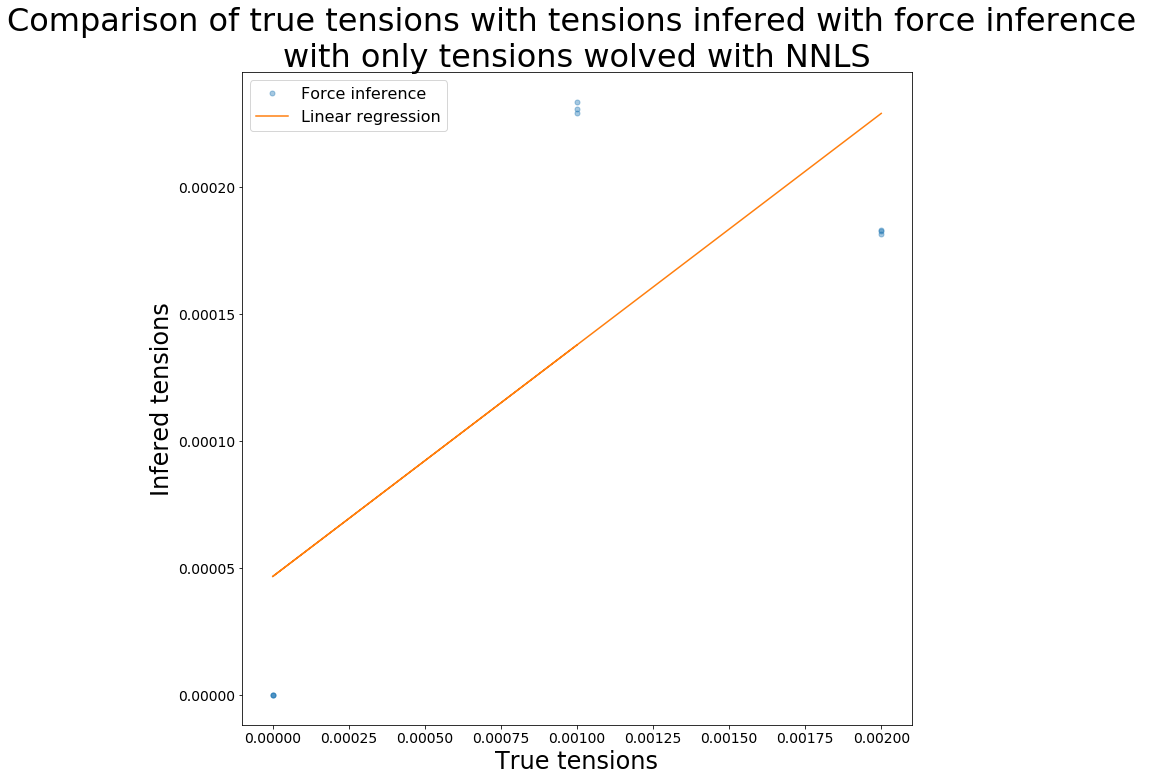

R value : 0.7483038947668337 
Standard error : 5.71446935194769e-05


In [8]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  rescaled_pressions_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

Distance minimization

`xtol` termination condition is satisfied.
Function evaluations 159, initial cost 2.3183e-06, final cost 8.3862e-19, first-order optimality 4.62e-14.
Solving time: 22.137031
Distance from th organo to exp organo : 0.0
Distance from th tensions to exp tensions : 0.0023750433920409477


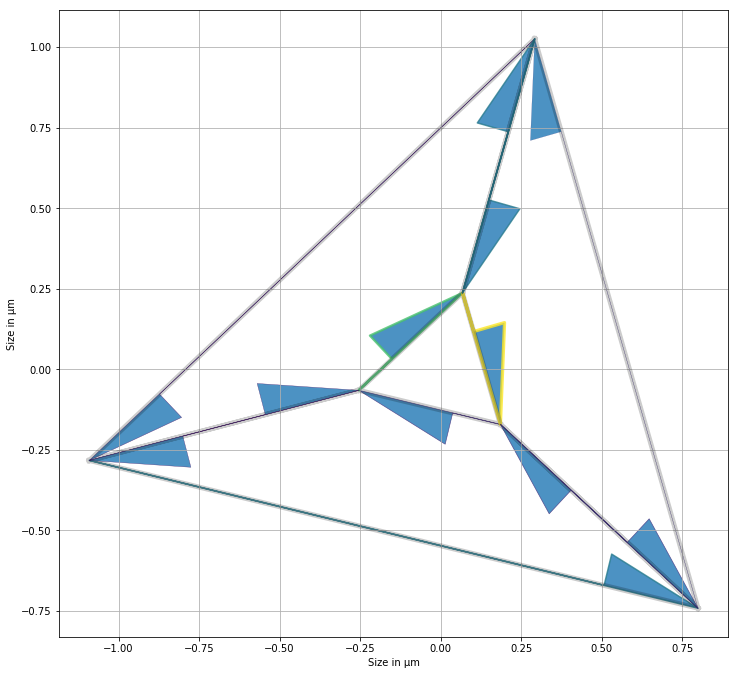

In [9]:
iprint_file = "../../assets/dist_at_each_f_ev/30_01_pressions2.txt"
res_sym_tensions = adjust_tensions(organo, opt_scale.x*initial_guess['tensions'], 
                                   {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                   energy_opt, iprint_file=iprint_file, **lm_opt)
opt_pressions_organo = organo.copy()
opt_pressions_organo.edge_df.line_tension = prepare_tensions(opt_pressions_organo, res_sym_tensions.x)
Solver.find_energy_min(opt_pressions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_pressions_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, opt_pressions_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                opt_pressions_organo.edge_df.line_tension[:3*nb_cells]))))

In [10]:
dist_init_point = np.sum(np.linalg.norm(_distance(rescaled_pressions_organo, opt_pressions_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(opt_pressions_organo, opt_pressions_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                             rescaled_pressions_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                         opt_pressions_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th organo to exp organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 0.00510480216723816
Distance from th organo to exp organo at optima: 0.0
Distance from th tensions to exp tensions at initial point : 0.0034183823721574175
Distance from th tensions to exp tensions at initial point : 0.0023750433920409477


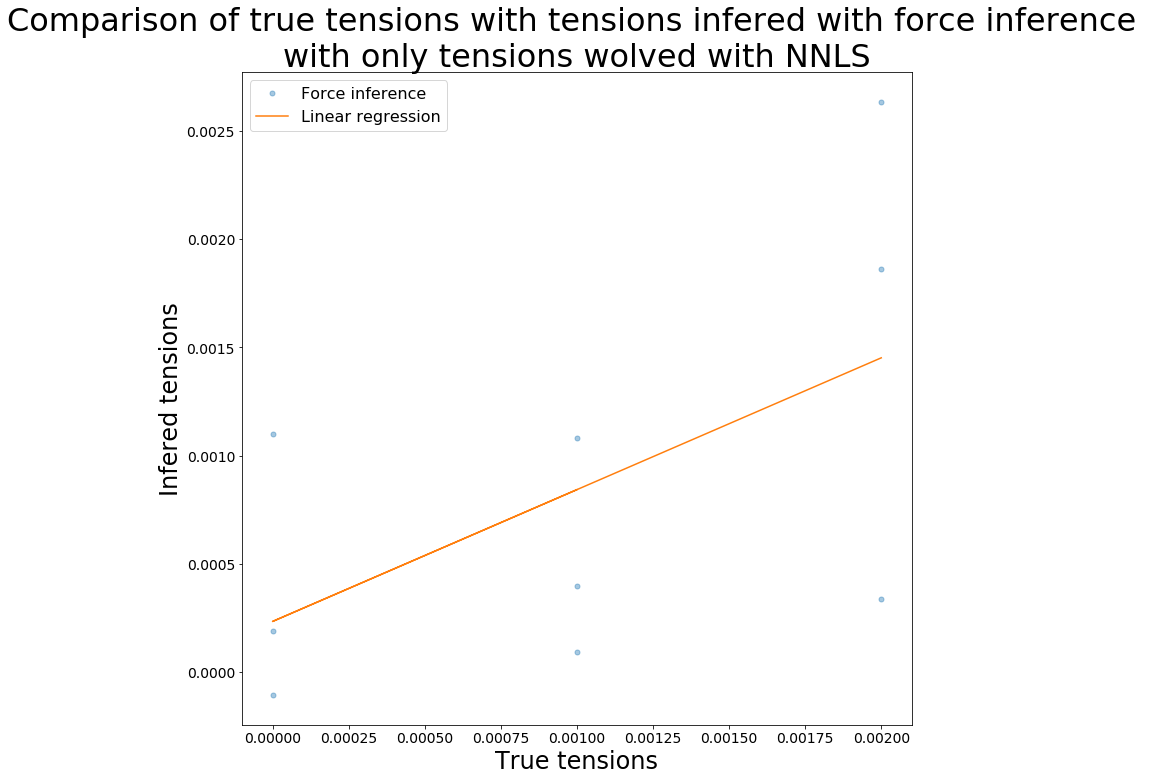

R value : 0.5757412005142865 
Standard error : 0.0006126646054382761


In [11]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  opt_pressions_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

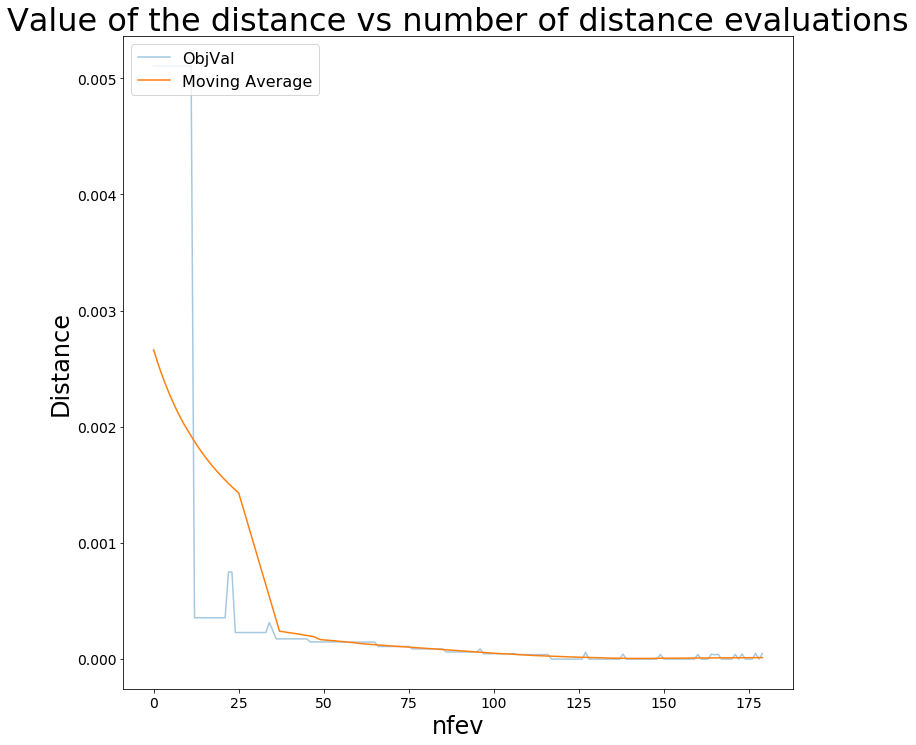

In [12]:
iter_data = pd.read_csv(iprint_file, header=None)
rendering_convergence_results(np.arange(len(iter_data[0])),
                              iter_data[0],
                              'Value of the distance vs number of distance evaluations',
                              'nfev', 'Distance', ('ObjVal', 'Moving Average'),
                              data_dot='-', rol_win=50)